# Projet de préduction de précipitations pour la région de Taroudant au Maroc - Groupe 1
## Réalisé par : MESKINE FATIMA EZZAHRA, BABADAIH Najlae, Ait Ben M'bark Ikram
### Veuillez trouvez notre dataset dans le meme répértoire sous nom: "taroudant_nwp_2000_2025.csv"
## Code source des pipelines xgboost et randomforest

### Pipeline Xgboost

LANCEMENT DU PIPELINE XGBOOST
PIPELINE XGBOOST INTELLIGENT

Chargement des données...
CHARGEMENT ET VÉRIFICATION DES DONNÉES
Données brutes chargées: (219552, 6)
Colonnes: ['time', 'temp_C', 'precip_mm', 'rh', 'wind_ms', 'pressure']

Période des données: 2000-01-01 00:00:00 à 2025-12-11 23:00:00
Nombre total d'heures: 219552
Nombre de jours: 9148.0

Création des features...

CRÉATION DES FEATURES INTELLIGENTES
Features créées: 56
Échantillons avant/après: 219552 → 219480

Split des données...

SPLIT TEMPOREL INTELLIGENT
TOTAL: 219480 échantillons (9145.0 jours)
Seuil: 0.8000 mm

Train:
  Échantillons: 153,636
  Valeurs élevées: 1,347 (0.88%)
  Moyenne: 0.0289 mm
  Max: 9.9000 mm
  Moyenne des valeurs élevées: 1.6156 mm

Validation:
  Échantillons: 32,922
  Valeurs élevées: 250 (0.76%)
  Moyenne: 0.0212 mm
  Max: 7.9000 mm
  Moyenne des valeurs élevées: 2.0136 mm

Test:
  Échantillons: 32,922
  Valeurs élevées: 176 (0.53%)
  Moyenne: 0.0168 mm
  Max: 15.1000 mm
  Moyenne des valeurs éle

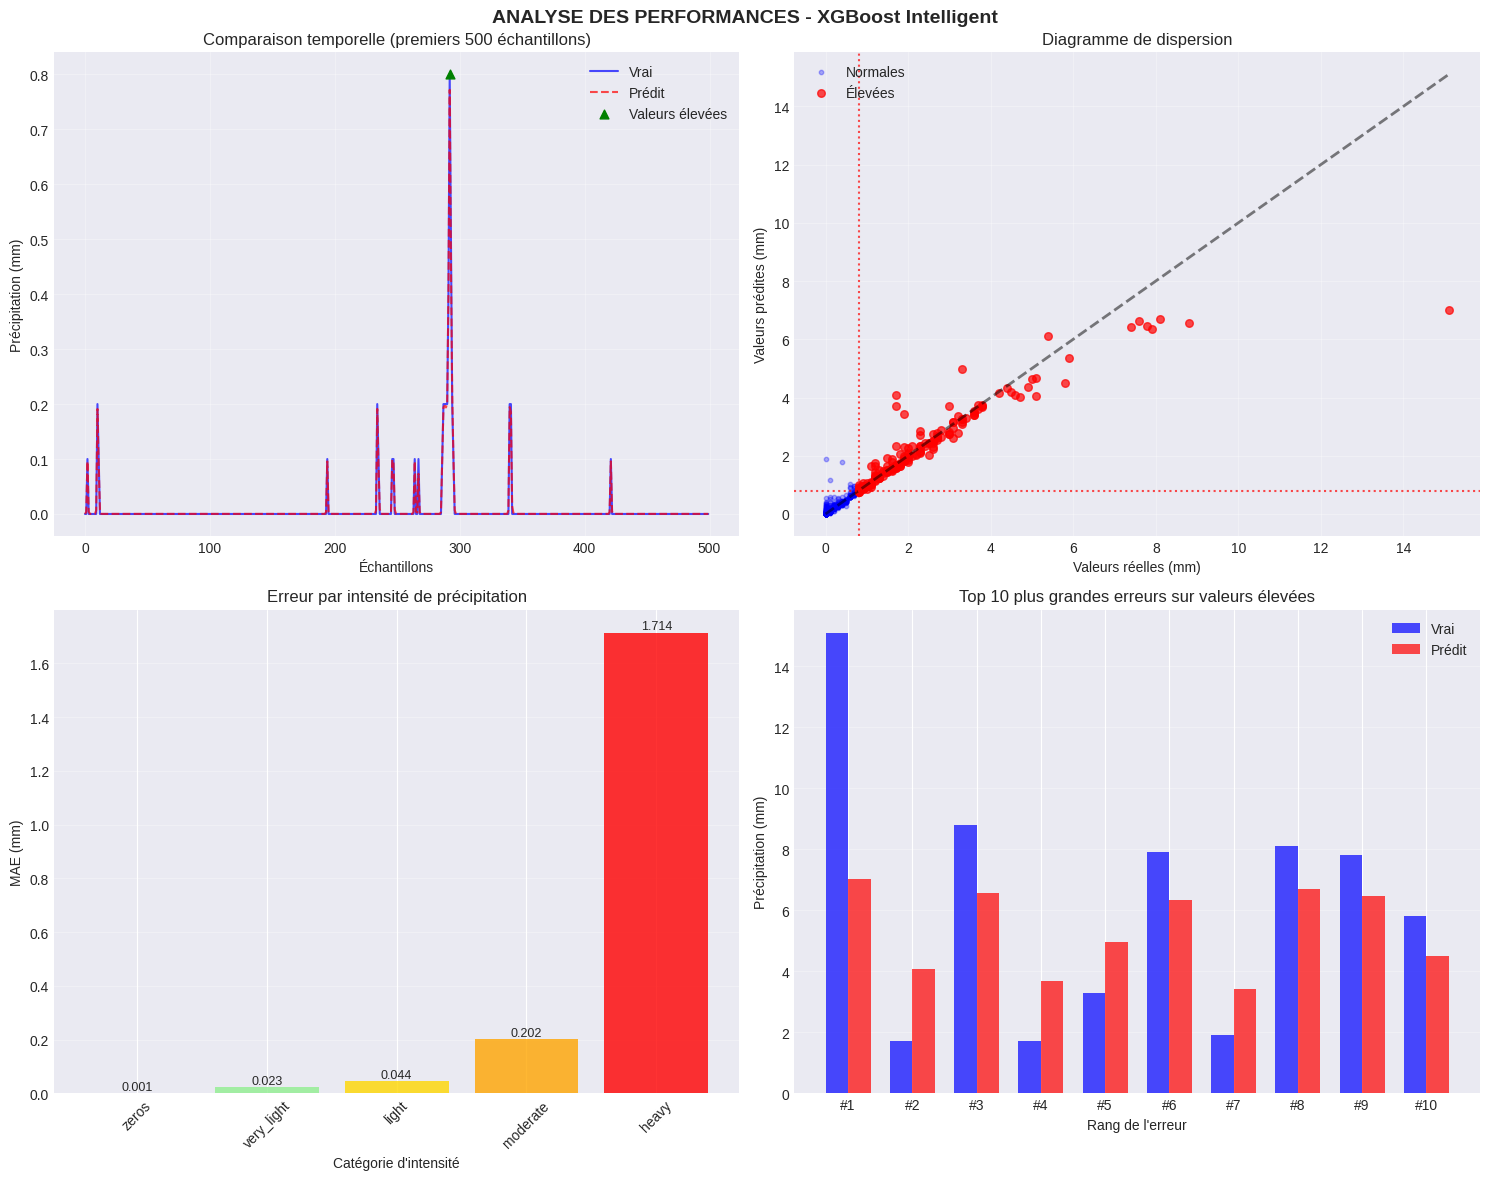

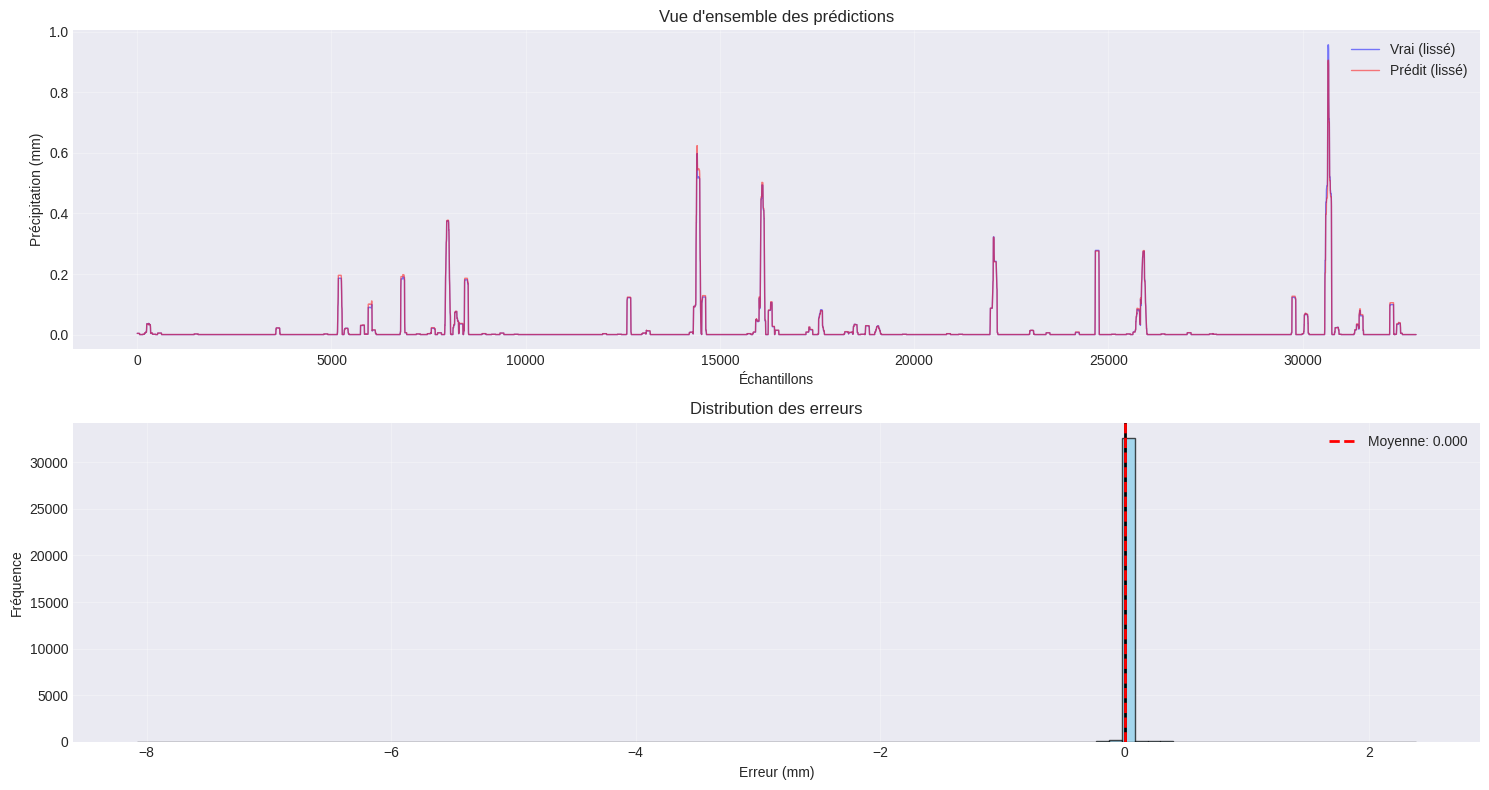


RÉSUMÉ STATISTIQUE

PERFORMANCE GLOBALE:
   MAE:  0.0027 mm
   RMSE: 0.0588 mm

PERFORMANCE SUR VALEURS ÉLEVÉES:
   Seuil: 0.80 mm
   MAE:  0.2825 mm
   RMSE: 0.7659 mm

Sauvegarde des résultats...
   Modèle sauvegardé: smart_xgboost_model.pkl
   Prédictions sauvegardées: smart_predictions.csv
   Résultats sauvegardés: smart_results.csv

PIPELINE TERMINÉ AVEC SUCCÈS!

modele entrainé!


In [ ]:

# Code XGBOOST

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d, binary_dilation
import xgboost as xgb
from datetime import timedelta

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def load_and_prepare_data(filepath):
    """Charger et préparer les données"""
    print("CHARGEMENT ET VÉRIFICATION DES DONNÉES")

    df = pd.read_csv(filepath)
    print(f"Données brutes chargées: {df.shape}")
    print(f"Colonnes: {df.columns.tolist()}")

    # Conversion du timestamp
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df = df.sort_index()

    print(f"\nPériode des données: {df.index.min()} à {df.index.max()}")
    print(f"Nombre total d'heures: {len(df)}")
    print(f"Nombre de jours: {len(df)/24:.1f}")

    # Imputation des valeurs manquantes
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if col in ['temp_C', 'pressure', 'rh']:
                df[col] = df[col].interpolate(method='time')
            else:
                df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

    return df

def create_smart_features(df, target_col='precip_mm'):
    """Feature engineering intelligent"""
    print("\nCRÉATION DES FEATURES INTELLIGENTES")

    df_features = df.copy()

    #Features temporelles de base
    df_features['hour'] = df_features.index.hour
    df_features['day_of_year'] = df_features.index.dayofyear
    df_features['month'] = df_features.index.month
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)

    #Features cycliques
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

    #Lags critiques
    lags = [1, 2, 3, 6, 12, 24, 48, 72]
    for lag in lags:
        df_features[f'{target_col}_lag_{lag}h'] = df_features[target_col].shift(lag)

    #Statistiques glissantes
    windows = [3, 6, 12, 24, 48]
    for window in windows:
        df_features[f'{target_col}_mean_{window}h'] = df_features[target_col].rolling(window).mean()
        df_features[f'{target_col}_max_{window}h'] = df_features[target_col].rolling(window).max()
        df_features[f'{target_col}_sum_{window}h'] = df_features[target_col].rolling(window).sum()
        df_features[f'{target_col}_std_{window}h'] = df_features[target_col].rolling(window).std()

    #Cumuls prédictifs
    for window in [3, 6, 12]:
        df_features[f'{target_col}_cumsum_prev_{window}h'] = df_features[target_col].rolling(window).sum().shift(1)

    #Features météorologiques avancées
    if all(col in df.columns for col in ['temp_C', 'rh']):
        df_features['dew_point'] = df_features['temp_C'] - ((100 - df_features['rh']) / 5)
        df_features['temp_rh_product'] = df_features['temp_C'] * df_features['rh']

    if 'pressure' in df.columns:
        df_features['pressure_change'] = df_features['pressure'].diff(3)

    # de changement
    df_features[f'{target_col}_diff_1h'] = df_features[target_col].diff(1)
    df_features[f'{target_col}_diff_3h'] = df_features[target_col].diff(3)
    df_features[f'{target_col}_acceleration'] = df_features[f'{target_col}_diff_1h'].diff(1)

    #Indicateurs avancés
    if len(df_features) > 100:
        if (df_features[target_col] > 0).any():
            p75 = df_features[target_col][df_features[target_col] > 0].quantile(0.75)
            p90 = df_features[target_col][df_features[target_col] > 0].quantile(0.90)
        else:
            p75 = p90 = 0

        df_features['is_heavy_rain'] = (df_features[target_col] > p75).astype(int)
        df_features['is_extreme_rain'] = (df_features[target_col] > p90).astype(int)

        for window in [6, 12, 24]:
            df_features[f'recent_peak_{window}h'] = df_features[target_col].rolling(window).max()

    # Nettoyage
    df_clean = df_features.dropna()

    print(f"Features créées: {len(df_clean.columns)}")
    print(f"Échantillons avant/après: {len(df_features)} → {len(df_clean)}")

    return df_clean

def create_time_split(df, target_col='precip_mm', test_ratio=0.15, val_ratio=0.15):
    """Split temporel intelligent"""
    print("\nSPLIT TEMPOREL INTELLIGENT")

    total_samples = len(df)
    feature_cols = [col for col in df.columns if col != target_col]
    X = df[feature_cols]
    y = df[target_col]

    # Calcul des indices
    train_end = int(total_samples * (1 - test_ratio - val_ratio))
    val_end = int(total_samples * (1 - test_ratio))

    # Seuil adaptatif
    if len(y) > 0 and (y > 0).any():
        threshold = np.percentile(y[y > 0], 85)
    else:
        threshold = np.percentile(y, 90) if len(y) > 0 else 0

    print(f"TOTAL: {total_samples} échantillons ({total_samples/24:.1f} jours)")
    print(f"Seuil: {threshold:.4f} mm")

    # Analyse des sous-ensembles
    subsets = [
        ('Train', slice(0, train_end)),
        ('Validation', slice(train_end, val_end)),
        ('Test', slice(val_end, total_samples))
    ]

    for name, idx_slice in subsets:
        y_subset = y.iloc[idx_slice]
        peaks = y_subset >= threshold

        print(f"\n{name}:")
        print(f"  Échantillons: {len(y_subset):,}")
        print(f"  Valeurs élevées: {peaks.sum():,} ({peaks.sum()/len(y_subset)*100:.2f}%)")
        print(f"  Moyenne: {y_subset.mean():.4f} mm")
        print(f"  Max: {y_subset.max():.4f} mm")
        if peaks.sum() > 0:
            print(f"  Moyenne des valeurs élevées: {y_subset[peaks].mean():.4f} mm")

    # Création des splits
    splits = {
        'X_train': X.iloc[:train_end],
        'y_train': y.iloc[:train_end],
        'X_val': X.iloc[train_end:val_end],
        'y_val': y.iloc[train_end:val_end],
        'X_test': X.iloc[val_end:],
        'y_test': y.iloc[val_end:],
        'feature_names': feature_cols,
        'threshold': threshold,
        'train_dates': X.iloc[:train_end].index,
        'val_dates': X.iloc[train_end:val_end].index,
        'test_dates': X.iloc[val_end:].index
    }

    return splits


#classe XGBOOST


class SmartXGBoostForPeaks:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.best_model = None
        self.feature_importance = None

    def _calculate_sample_weights(self, y, threshold=None):
        """Calcul de poids intelligents"""
        y = np.array(y)

        if threshold is None:
            if (y > 0).any():
                threshold = np.percentile(y[y > 0], 80)
            else:
                threshold = np.percentile(y, 85) if len(y) > 0 else 0

        weights = np.ones_like(y, dtype=np.float32)

        #Renforcer les valeurs élevées
        peak_mask = y >= threshold
        if peak_mask.any():
            peak_intensity = y[peak_mask] / (y.max() + 1e-10)
            weights[peak_mask] = 3.0 + 10.0 * peak_intensity

        #Précurseurs (1-3h avant une valeur élevée)
        for i in range(len(y)):
            for hours_ahead in [1, 2, 3]:
                if i + hours_ahead < len(y) and y[i + hours_ahead] >= threshold:
                    weight_decay = 1.0 / hours_ahead
                    weights[i] = max(weights[i], 2.0 * weight_decay)

        #Normalisation
        weights = weights / weights.mean()

        return weights

    def train_with_cross_validation(self, X_train, y_train, X_val, y_val, n_folds=3):
        """Entraînement avec validation croisée temporelle"""
        print("\nENTRAÎNEMENT AVEC VALIDATION CROISÉE")

        # Paramètres optimisés manuellement
        best_params = {
            'n_estimators': 500,
            'max_depth': 8,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 5,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'gamma': 0.1,
            'random_state': self.random_state,
            'n_jobs': -1,
            'objective': 'reg:squarederror',
            'eval_metric': 'mae'
        }

        # Calcul des poids
        sample_weights = self._calculate_sample_weights(y_train)

        print(f"Configuration:")
        print(f"   n_estimators: {best_params['n_estimators']}")
        print(f"   max_depth: {best_params['max_depth']}")
        print(f"   learning_rate: {best_params['learning_rate']:.3f}")

        # Création du modèle
        model = XGBRegressor(**best_params)

        try:
            print("\nEntraînement du modèle...")

            # Conversion pour compatibilité
            X_train_array = X_train.values if hasattr(X_train, 'values') else X_train
            X_val_array = X_val.values if hasattr(X_val, 'values') else X_val
            y_train_array = y_train.values if hasattr(y_train, 'values') else y_train
            y_val_array = y_val.values if hasattr(y_val, 'values') else y_val

            # Entraînement avec eval_set
            model.fit(
                X_train_array, y_train_array,
                sample_weight=sample_weights,
                eval_set=[(X_train_array, y_train_array), (X_val_array, y_val_array)],
                verbose=50,
                early_stopping_rounds=30
            )

            print(f"Entraînement terminé")
            if hasattr(model, 'best_iteration'):
                print(f"   Meilleure itération: {model.best_iteration}")

        except Exception as e:
            print(f"Warning: Early stopping non supporté: {e}")
            print("   Utilisation sans early stopping...")

            model.fit(
                X_train, y_train,
                sample_weight=sample_weights,
                verbose=50
            )

        # Sauvegarde du modèle
        self.best_model = model
        self.models['main'] = {
            'model': model,
            'params': best_params
        }

        # Calcul de l'importance des features
        self._calculate_feature_importance(X_train.columns)

        return model

    def _calculate_feature_importance(self, feature_names):
        """Calcul de l'importance des features"""
        if self.best_model is None:
            return

        try:
            importances = self.best_model.feature_importances_
            self.feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            print(f"\nTOP 15 FEATURES PAR IMPORTANCE:")
            for i, (_, row) in enumerate(self.feature_importance.head(15).iterrows()):
                print(f"  {i+1:2d}. {row['feature']:30s}: {row['importance']:.4f}")

        except Exception as e:
            print(f"Warning: Impossible de calculer l'importance des features: {e}")

    def predict(self, X):
        """Prédiction avec post-processing"""
        if self.best_model is None:
            raise ValueError("Modèle non entraîné")

        # Prédiction
        y_pred = self.best_model.predict(X)

        # Post-processing
        y_pred = np.maximum(y_pred, 0)

        # Lissage léger
        if len(y_pred) > 10:
            y_pred_smooth = gaussian_filter1d(y_pred, sigma=0.5)
            y_pred = 0.7 * y_pred + 0.3 * y_pred_smooth

        return y_pred

    def evaluate(self, X, y_true, splits_info=None, verbose=True):
        """Évaluation complète"""
        y_pred = self.predict(X)

        # Conversion en numpy arrays
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Métriques globales
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        results = {
            'global': {'mae': mae, 'rmse': rmse, 'r2': r2},
            'by_intensity': {},
            'high_values': {}
        }

        if verbose:
            print("\nÉVALUATION DÉTAILLÉE")
            print(f"MAE global:  {mae:.4f}")
            print(f"RMSE global: {rmse:.4f}")
            print(f"R² global:   {r2:.4f}")

        # Analyse par intensité
        intensity_categories = {
            'zeros': (0, 0),
            'very_light': (0, 0.1),
            'light': (0.1, 1.0),
            'moderate': (1.0, 5.0),
            'heavy': (5.0, np.inf)
        }

        for category, (low, high) in intensity_categories.items():
            if category == 'zeros':
                mask = y_true == 0
            elif high == np.inf:
                mask = y_true > low
            else:
                mask = (y_true > low) & (y_true <= high)

            if mask.sum() > 0:
                cat_y_true = y_true[mask]
                cat_y_pred = y_pred[mask]

                cat_mae = mean_absolute_error(cat_y_true, cat_y_pred)
                cat_rmse = np.sqrt(mean_squared_error(cat_y_true, cat_y_pred))
                cat_r2 = r2_score(cat_y_true, cat_y_pred) if len(np.unique(cat_y_true)) > 1 else 0

                results['by_intensity'][category] = {
                    'mae': cat_mae, 'rmse': cat_rmse, 'r2': cat_r2,
                    'count': mask.sum()
                }

                if verbose:
                    print(f"\n{category.upper()} ({low}-{high if high != np.inf else 'inf'} mm):")
                    print(f"  Nombre: {mask.sum()} ({mask.sum()/len(y_true)*100:.1f}%)")
                    print(f"  MAE:  {cat_mae:.4f}")
                    print(f"  RMSE: {cat_rmse:.4f}")
                    print(f"  R²:   {cat_r2:.4f}")

        # Analyse des valeurs élevées
        if splits_info and 'threshold' in splits_info:
            threshold = splits_info['threshold']
        else:
            if (y_true > 0).any():
                threshold = np.percentile(y_true[y_true > 0], 85)
            else:
                threshold = np.percentile(y_true, 90) if len(y_true) > 0 else 0

        high_mask = y_true >= threshold

        if high_mask.sum() > 0:
            high_y_true = y_true[high_mask]
            high_y_pred = y_pred[high_mask]

            high_mae = mean_absolute_error(high_y_true, high_y_pred)
            high_rmse = np.sqrt(mean_squared_error(high_y_true, high_y_pred))
            high_r2 = r2_score(high_y_true, high_y_pred) if len(np.unique(high_y_true)) > 1 else 0

            # Détection
            predicted_high = y_pred >= threshold
            true_positives = np.sum(high_mask & predicted_high)
            false_positives = np.sum(~high_mask & predicted_high)
            false_negatives = np.sum(high_mask & ~predicted_high)

            precision = true_positives / (true_positives + false_positives + 1e-10)
            recall = true_positives / (true_positives + false_negatives + 1e-10)
            f1_score = 2 * precision * recall / (precision + recall + 1e-10)

            results['high_values'] = {
                'threshold': threshold,
                'mae': high_mae, 'rmse': high_rmse, 'r2': high_r2,
                'count': high_mask.sum(),
                'true_positives': true_positives,
                'false_positives': false_positives,
                'false_negatives': false_negatives,
                'precision': precision, 'recall': recall, 'f1': f1_score,
                'detection_rate': recall
            }

            if verbose:
                print(f"\nVALEURS ÉLEVÉES (≥ {threshold:.4f} mm):")
                print(f"  Nombre: {high_mask.sum()} ({high_mask.sum()/len(y_true)*100:.1f}%)")
                print(f"  MAE:  {high_mae:.4f}")
                print(f"  RMSE: {high_rmse:.4f}")



        return y_pred, results


#VISUALISATIONS SIMPLIFIÉES


def create_smart_visualizations(splits, y_pred, results, model_name="XGBoost"):
    """Visualisations intelligentes et lisibles"""

    y_true = splits['y_test'].values
    dates = splits['test_dates']

    #Figure principale
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1.1 Comparaison temporelle (500 premiers échantillons)
    ax1 = axes[0, 0]
    n_show = min(500, len(y_true))

    ax1.plot(range(n_show), y_true[:n_show], 'b-', alpha=0.7, linewidth=1.5, label='Vrai')
    ax1.plot(range(n_show), y_pred[:n_show], 'r--', alpha=0.7, linewidth=1.5, label='Prédit')

    # Marquer les valeurs élevées
    threshold = results.get('high_values', {}).get('threshold', 0)
    true_high = y_true[:n_show] >= threshold
    if true_high.any():
        ax1.scatter(np.where(true_high)[0], y_true[:n_show][true_high],
                   c='green', s=40, marker='^', label='Valeurs élevées', zorder=5)

    ax1.set_xlabel('Échantillons')
    ax1.set_ylabel('Précipitation (mm)')
    ax1.set_title(f'Comparaison temporelle (premiers {n_show} échantillons)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # 1.2 Diagramme de dispersion
    ax2 = axes[0, 1]

    # Points normaux en bleu, valeurs élevées en rouge
    normal_mask = y_true < threshold
    high_mask = y_true >= threshold

    if normal_mask.any():
        ax2.scatter(y_true[normal_mask], y_pred[normal_mask],
                   alpha=0.3, s=10, c='blue', label='Normales')

    if high_mask.any():
        ax2.scatter(y_true[high_mask], y_pred[high_mask],
                   alpha=0.7, s=30, c='red', label='Élevées')

    max_val = max(y_true.max(), y_pred.max())
    ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2)
    ax2.axvline(x=threshold, color='r', linestyle=':', alpha=0.7)
    ax2.axhline(y=threshold, color='r', linestyle=':', alpha=0.7)

    ax2.set_xlabel('Valeurs réelles (mm)')
    ax2.set_ylabel('Valeurs prédites (mm)')
    ax2.set_title('Diagramme de dispersion')
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

    # 1.3 Performance par catégorie
    ax3 = axes[1, 0]

    categories = []
    mae_values = []
    colors = ['lightblue', 'lightgreen', 'gold', 'orange', 'red']

    for i, (cat, metrics) in enumerate(results['by_intensity'].items()):
        if metrics['count'] > 0:
            categories.append(cat)
            mae_values.append(metrics['mae'])

    bars = ax3.bar(categories, mae_values, color=colors[:len(categories)], alpha=0.8)
    ax3.set_xlabel('Catégorie d\'intensité')
    ax3.set_ylabel('MAE (mm)')
    ax3.set_title('Erreur par intensité de précipitation')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')

    for bar, mae in zip(bars, mae_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{mae:.3f}', ha='center', va='bottom', fontsize=9)

    # 1.4 Top 10 erreurs sur les valeurs élevées
    ax4 = axes[1, 1]

    if 'high_values' in results:
        high_mask = y_true >= results['high_values']['threshold']
        if high_mask.sum() > 0:
            high_indices = np.where(high_mask)[0]
            high_errors = np.abs(y_pred[high_mask] - y_true[high_mask])

            # Top 10 erreurs
            n_top = min(10, len(high_errors))
            top_indices = np.argsort(high_errors)[-n_top:][::-1]

            x_pos = range(n_top)
            width = 0.35

            true_values = y_true[high_indices][top_indices]
            pred_values = y_pred[high_indices][top_indices]

            ax4.bar([x - width/2 for x in x_pos], true_values, width,
                   label='Vrai', alpha=0.7, color='blue')
            ax4.bar([x + width/2 for x in x_pos], pred_values, width,
                   label='Prédit', alpha=0.7, color='red')

            ax4.set_xlabel('Rang de l\'erreur')
            ax4.set_ylabel('Précipitation (mm)')
            ax4.set_title(f'Top {n_top} plus grandes erreurs sur valeurs élevées')
            ax4.set_xticks(x_pos)
            ax4.set_xticklabels([f'#{i+1}' for i in range(n_top)])
            ax4.legend(loc='upper right')
            ax4.grid(True, alpha=0.3, axis='y')
        else:
            ax4.text(0.5, 0.5, 'Aucune valeur élevée détectée',
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Erreurs sur valeurs élevées')

    plt.suptitle(f'ANALYSE DES PERFORMANCES - {model_name}',
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

    #Visualisation des séries temporelles complètes
    fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    # 2.1 Vue globale (version lissée)
    if len(y_true) > 1000:
        window = min(100, len(y_true) // 10)
        true_smooth = np.convolve(y_true, np.ones(window)/window, mode='same')
        pred_smooth = np.convolve(y_pred, np.ones(window)/window, mode='same')

        ax1.plot(range(len(y_true)), true_smooth, 'b-', alpha=0.5, linewidth=1, label='Vrai (lissé)')
        ax1.plot(range(len(y_pred)), pred_smooth, 'r-', alpha=0.5, linewidth=1, label='Prédit (lissé)')
    else:
        ax1.plot(range(len(y_true)), y_true, 'b-', alpha=0.3, linewidth=0.5, label='Vrai')
        ax1.plot(range(len(y_pred)), y_pred, 'r-', alpha=0.3, linewidth=0.5, label='Prédit')

    ax1.set_xlabel('Échantillons')
    ax1.set_ylabel('Précipitation (mm)')
    ax1.set_title('Vue d\'ensemble des prédictions')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    # 2.2 Distribution des erreurs
    errors = y_pred - y_true
    ax2.hist(errors, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax2.axvline(x=errors.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Moyenne: {errors.mean():.3f}')

    ax2.set_xlabel('Erreur (mm)')
    ax2.set_ylabel('Fréquence')
    ax2.set_title('Distribution des erreurs')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    #Résumé statistique
    print("\nRÉSUMÉ STATISTIQUE")

    print(f"\nPERFORMANCE GLOBALE:")
    print(f"   MAE:  {results['global']['mae']:.4f} mm")
    print(f"   RMSE: {results['global']['rmse']:.4f} mm")

    if 'high_values' in results:
        print(f"\nPERFORMANCE SUR VALEURS ÉLEVÉES:")
        print(f"   Seuil: {results['high_values']['threshold']:.2f} mm")
        print(f"   MAE:  {results['high_values']['mae']:.4f} mm")
        print(f"   RMSE: {results['high_values']['rmse']:.4f} mm")


#PIPELINE PRINCIPAL CORRIGÉ


def run_smart_pipeline(filepath, target_col='precip_mm'):
    """Pipeline principal corrigé et simplifié"""

    print("PIPELINE XGBOOST INTELLIGENT")

    try:
        #Chargement des données
        print("\nChargement des données...")
        df = load_and_prepare_data(filepath)

        #Feature engineering
        print("\nCréation des features...")
        df_features = create_smart_features(df, target_col)

        #Split temporel
        print("\nSplit des données...")
        splits = create_time_split(df_features, target_col)

        #Analyse des données
        print("\nAnalyse des données d'entraînement...")
        y_train = splits['y_train']
        print(f"   Distribution de {target_col}:")
        print(f"     Min: {y_train.min():.4f}")
        print(f"     Max: {y_train.max():.4f}")
        print(f"     Mean: {y_train.mean():.4f}")
        print(f"     Std: {y_train.std():.4f}")

        # Calcul du seuil
        if (y_train > 0).any():
            threshold = np.percentile(y_train[y_train > 0], 85)
            print(f"     Seuil (85e percentile): {threshold:.4f} mm")

        #Entraînement du modèle
        print("\nEntraînement du modèle XGBoost...")
        model = SmartXGBoostForPeaks(random_state=42)

        model.train_with_cross_validation(
            splits['X_train'], splits['y_train'],
            splits['X_val'], splits['y_val']
        )

        #Évaluation
        print("\nÉvaluation sur l'ensemble de test...")
        y_pred_test, test_results = model.evaluate(
            splits['X_test'], splits['y_test'],
            splits_info={'threshold': splits['threshold']},
            verbose=True
        )

        #Visualisations
        print("\nGénération des visualisations...")
        create_smart_visualizations(splits, y_pred_test, test_results,
                                   model_name="XGBoost Intelligent")

        #Sauvegarde
        print("\nSauvegarde des résultats...")

        # Modèle
        joblib.dump(model, 'smart_xgboost_model.pkl')
        print("   Modèle sauvegardé: smart_xgboost_model.pkl")

        # Prédictions
        predictions_df = pd.DataFrame({
            'date': splits['test_dates'],
            'true': splits['y_test'].values,
            'pred': y_pred_test,
            'error': y_pred_test - splits['y_test'].values,
            'abs_error': np.abs(y_pred_test - splits['y_test'].values)
        })
        predictions_df.to_csv('smart_predictions.csv', index=False)
        print("   Prédictions sauvegardées: smart_predictions.csv")

        # Résultats
        results_df = pd.DataFrame({
            'metric': ['MAE', 'RMSE', 'R2', 'High_MAE', 'High_RMSE', 'High_R2',
                      'Recall', 'Precision', 'F1_Score'],
            'value': [
                test_results['global']['mae'],
                test_results['global']['rmse'],
                test_results['global']['r2'],
                test_results.get('high_values', {}).get('mae', 0),
                test_results.get('high_values', {}).get('rmse', 0),
                test_results.get('high_values', {}).get('r2', 0),
                test_results.get('high_values', {}).get('recall', 0),
                test_results.get('high_values', {}).get('precision', 0),
                test_results.get('high_values', {}).get('f1', 0)
            ]
        })
        results_df.to_csv('smart_results.csv', index=False)
        print("   Résultats sauvegardés: smart_results.csv")

        print("\nPIPELINE TERMINÉ AVEC SUCCÈS!")

        return model, splits, test_results, y_pred_test

    except Exception as e:
        print(f"\nERREUR: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None


#EXÉCUTION


if __name__ == "__main__":
    print("LANCEMENT DU PIPELINE XGBOOST")

    DATA_FILE = 'taroudant_nwp_2000_2025.csv'

    model, splits, results, y_pred = run_smart_pipeline(DATA_FILE)

    if model is not None:
        print("\nmodele entrainé!")

### Pipeline RANDOM FOREST

LANCEMENT DU RANDOM FOREST OPTIMISÉ
RANDOM FOREST OPTIMISÉ

Chargement des données...
Chargement du fichier: taroudant_nwp_2000_2025.csv
Données chargées: 219552 lignes, 5 colonnes
Plage temporelle: 2000-01-01 00:00:00 à 2025-12-11 23:00:00

Colonne cible: precip_mm
Statistiques: min=0.0000, max=15.1000, moyenne=0.0259

Création des features...
Features créées: 38 colonnes, 219528 échantillons

Split des données...
Split temporel:
  Train: 186598 échantillons (2000-01-02 00:00:00 à 2021-04-15 21:00:00)
  Test:  32930 échantillons (2021-04-15 22:00:00 à 2025-12-11 23:00:00)

Focus sur les valeurs élevées...
Dataset focalisé:
  Échantillons originaux: 186598
  Échantillons sélectionnés: 20000
  Valeurs élevées conservées: 1597
  Seuil: 0.8000 mm

Entraînement du Random Forest...
Début de l'entraînement...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    0.2s finished


Entraînement terminé en 5.7 secondes

Évaluation du modèle...

PERFORMANCE SUR VALEURS ÉLEVÉES (≥ 0.8 mm):
   Nombre de valeurs élevées: 176
   MAE sur valeurs élevées: 0.2570
   RMSE sur valeurs élevées: 0.7488
   Rappel: 97.73%
   Précision: 81.90%
   F1-score: 89.12%

PERFORMANCE GLOBALE:
   MAE:  0.0038
   RMSE: 0.0720

Visualisation des résultats...


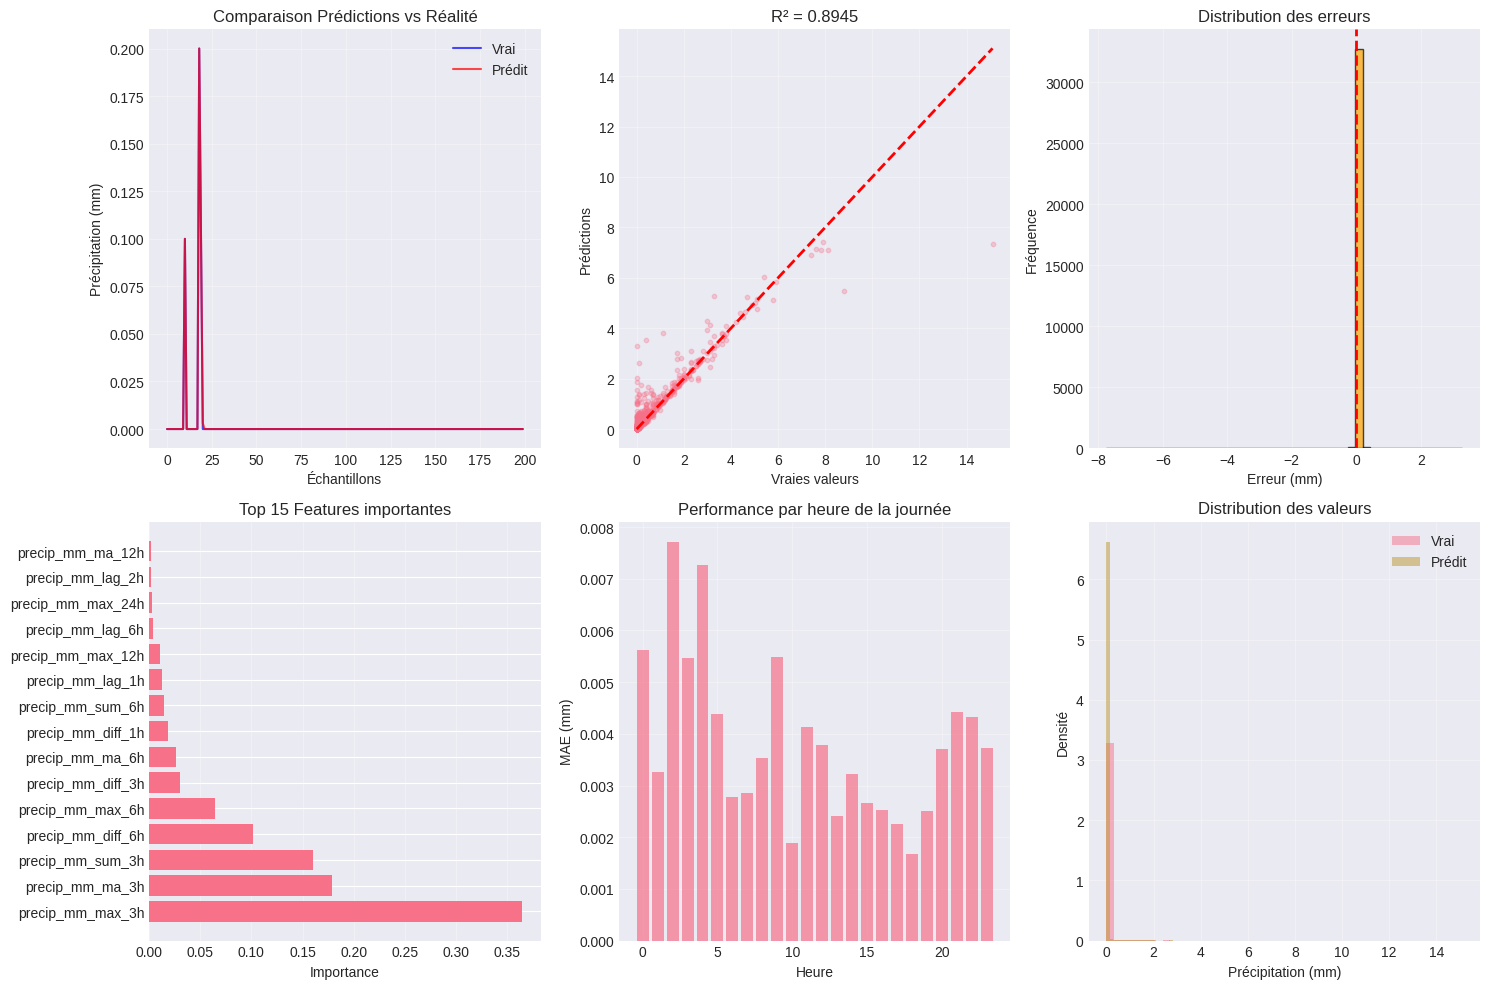


Sauvegarde des résultats...
   Modèle sauvegardé: rf_model.pkl
   Prédictions sauvegardées: rf_predictions.csv
   Métriques sauvegardées: rf_metrics.csv

RÉSUMÉ FINAL

MÉTRIQUES CLÉS:
   MAE global:  0.0038
   RMSE global: 0.0720

PERFORMANCE:
   Temps d'entraînement: 5.7s
   Taille du dataset: 20000 échantillons
   Nombre de features: 37

Pipeline terminé avec succès!

PIPELINE RANDOM FOREST TERMINÉ!

MÉTRIQUES FINALES:
   MAE:  0.0038
   RMSE: 0.0720


In [ ]:

# RANDOM FOREST

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')
import time
from scipy import stats

def load_and_prepare_data(filepath):
    """
    Charge et prépare les données météorologiques
    """
    print(f"Chargement du fichier: {filepath}")
    df = pd.read_csv(filepath)

    # Conversion de la colonne temporelle
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
    elif 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    print(f"Données chargées: {df.shape[0]} lignes, {df.shape[1]} colonnes")
    print(f"Plage temporelle: {df.index.min()} à {df.index.max()}")

    return df

def create_predictive_features(df, target_col='precip_mm'):
    """
    Crée des caractéristiques spécifiques pour la prédiction
    """
    df_features = df.copy()

    # Caractéristiques temporelles
    df_features['hour'] = df_features.index.hour
    df_features['month'] = df_features.index.month
    df_features['day_of_year'] = df_features.index.dayofyear
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['quarter'] = df_features.index.quarter

    # Transformations cycliques
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

    # Lag features critiques pour la pluie
    lag_hours = [1, 2, 3, 6, 12, 24]

    for lag in lag_hours:
        df_features[f'{target_col}_lag_{lag}h'] = df_features[target_col].shift(lag)

    # Moyennes mobiles pour détecter les tendances
    for window in [3, 6, 12, 24]:
        df_features[f'{target_col}_ma_{window}h'] = df_features[target_col].rolling(window).mean()
        df_features[f'{target_col}_max_{window}h'] = df_features[target_col].rolling(window).max()
        df_features[f'{target_col}_sum_{window}h'] = df_features[target_col].rolling(window).sum()

    # Différences pour détecter les changements brusques
    for period in [1, 3, 6]:
        df_features[f'{target_col}_diff_{period}h'] = df_features[target_col] - df_features[target_col].shift(period)

    # Caractéristiques météorologiques avancées
    if 'temp_C' in df_features.columns and 'rh' in df_features.columns:
        # Point de rosée - indicateur important pour la pluie
        df_features['dew_point'] = 243.04 * (np.log(df_features['rh']/100) +
                                            (17.625 * df_features['temp_C'])/(243.04 + df_features['temp_C'])) / \
                                 (17.625 - np.log(df_features['rh']/100) -
                                  (17.625 * df_features['temp_C'])/(243.04 + df_features['temp_C']))

        # Déséquilibre température/humidité
        df_features['temp_rh_imbalance'] = df_features['temp_C'] - (df_features['rh'] / 10)

    # Indicateurs
    df_features['is_potential_rain'] = ((df_features['rh'] > 80) if 'rh' in df_features.columns else 0).astype(int)

    # Remplissage des NaN
    df_features = df_features.dropna()

    print(f"Features créées: {df_features.shape[1]} colonnes, {df_features.shape[0]} échantillons")

    return df_features

def create_time_split(df, target_col='precip_mm', test_size=0.15):
    """
    Crée une séparation temporelle simple
    """
    split_idx = int(len(df) * (1 - test_size))

    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    test_dates = df.index[split_idx:]

    print(f"Split temporel:")
    print(f"  Train: {X_train.shape[0]} échantillons ({X_train.index.min()} à {X_train.index.max()})")
    print(f"  Test:  {X_test.shape[0]} échantillons ({X_test.index.min()} à {X_test.index.max()})")

    return X_train, X_test, y_train, y_test, test_dates

def create_focused_dataset(X_train, y_train, threshold_percentile=85):
    """
    Crée un dataset focalisé sur les valeurs élevées
    """
    y_train_values = y_train.values

    # Identifier les valeurs élevées
    if (y_train_values > 0).any():
        threshold = np.percentile(y_train_values[y_train_values > 0], threshold_percentile)
    else:
        threshold = 0

    high_indices = np.where(y_train_values >= threshold)[0]
    low_indices = np.where(y_train_values < threshold)[0]

    # Stratégie: toutes les valeurs élevées + échantillon équilibré des faibles
    n_samples = min(20000, len(X_train))
    n_low = min(n_samples - len(high_indices), len(low_indices))

    if n_low > 0:
        low_sample = np.random.choice(low_indices, size=n_low, replace=False)
        selected_indices = np.concatenate([high_indices, low_sample])
    else:
        selected_indices = high_indices

    X_train_focused = X_train.iloc[selected_indices]
    y_train_focused = y_train.iloc[selected_indices]

    print(f"Dataset focalisé:")
    print(f"  Échantillons originaux: {len(X_train)}")
    print(f"  Échantillons sélectionnés: {len(X_train_focused)}")
    print(f"  Valeurs élevées conservées: {len(high_indices)}")
    print(f"  Seuil: {threshold:.4f} mm")

    return X_train_focused, y_train_focused

def evaluate_model(y_true, y_pred, threshold=0.8):
    """
    Évalue le modèle avec des métriques détaillées
    """
    # Métriques globales
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Métriques pour les valeurs élevées
    is_high_true = y_true >= threshold
    is_high_pred = y_pred >= threshold

    if is_high_true.any():
        high_mae = mean_absolute_error(y_true[is_high_true], y_pred[is_high_true])
        high_rmse = np.sqrt(mean_squared_error(y_true[is_high_true], y_pred[is_high_true]))

        # Métriques de classification pour les valeurs élevées
        tp = np.sum(is_high_true & is_high_pred)  # True positives
        fp = np.sum(~is_high_true & is_high_pred)  # False positives
        fn = np.sum(is_high_true & ~is_high_pred)  # False negatives

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\nPERFORMANCE SUR VALEURS ÉLEVÉES (≥ {threshold} mm):")
        print(f"   Nombre de valeurs élevées: {is_high_true.sum()}")
        print(f"   MAE sur valeurs élevées: {high_mae:.4f}")
        print(f"   RMSE sur valeurs élevées: {high_rmse:.4f}")
        print(f"   Rappel: {recall:.2%}")
        print(f"   Précision: {precision:.2%}")
        print(f"   F1-score: {f1:.2%}")

    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'high_recall': recall if is_high_true.any() else 0,
        'high_precision': precision if is_high_true.any() else 0,
        'high_f1': f1 if is_high_true.any() else 0
    }

def optimized_random_forest_pipeline(filepath, target_col='precip_mm'):
    """
    Pipeline Random Forest optimisé
    """
    print("RANDOM FOREST OPTIMISÉ")

    #Chargement des données
    print("\nChargement des données...")
    df = load_and_prepare_data(filepath)

    # Vérifier la colonne cible
    if target_col not in df.columns:
        # Chercher des alternatives
        possible_targets = [col for col in df.columns if 'precip' in col.lower() or 'rain' in col.lower()]
        if possible_targets:
            target_col = possible_targets[0]
            print(f"Utilisation de '{target_col}' comme colonne cible.")
        else:
            target_col = df.columns[-1]
            print(f"Utilisation de '{target_col}' comme colonne cible (par défaut).")

    print(f"\nColonne cible: {target_col}")
    print(f"Statistiques: min={df[target_col].min():.4f}, max={df[target_col].max():.4f}, "
          f"moyenne={df[target_col].mean():.4f}")

    #Création des features
    print("\nCréation des features...")
    df_features = create_predictive_features(df, target_col)

    #Split des données
    print("\nSplit des données...")
    X_train, X_test, y_train, y_test, test_dates = create_time_split(df_features, target_col, test_size=0.15)

    #Création du dataset focalisé sur les valeurs élevées
    print("\nFocus sur les valeurs élevées...")
    X_train_focused, y_train_focused = create_focused_dataset(X_train, y_train, threshold_percentile=85)

    #Entraînement du modèle
    print("\nEntraînement du Random Forest...")

    # Configuration optimisée
    rf_model = RandomForestRegressor(
        n_estimators=150,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features=0.5,
        bootstrap=True,
        max_samples=0.8,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    print("Début de l'entraînement...")
    start_time = time.time()
    rf_model.fit(X_train_focused, y_train_focused)
    training_time = time.time() - start_time

    print(f"Entraînement terminé en {training_time:.1f} secondes")

    # Prédiction et évaluation
    print("\nÉvaluation du modèle...")
    y_pred = rf_model.predict(X_test)

    # Évaluation détaillée
    metrics = evaluate_model(y_test, y_pred, threshold=0.8)

    print(f"\nPERFORMANCE GLOBALE:")
    print(f"   MAE:  {metrics['mae']:.4f}")
    print(f"   RMSE: {metrics['rmse']:.4f}")

    #Visualisation
    print("\nVisualisation des résultats...")

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Graphique 1: Comparaison des prédictions
    axes[0, 0].plot(y_test.values[:200], label='Vrai', color='blue', alpha=0.7)
    axes[0, 0].plot(y_pred[:200], label='Prédit', color='red', alpha=0.7)
    axes[0, 0].set_xlabel('Échantillons')
    axes[0, 0].set_ylabel('Précipitation (mm)')
    axes[0, 0].set_title('Comparaison Prédictions vs Réalité')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Graphique 2: Nuage de points
    axes[0, 1].scatter(y_test, y_pred, alpha=0.3, s=10)
    max_val = max(y_test.max(), y_pred.max())
    axes[0, 1].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    axes[0, 1].set_xlabel('Vraies valeurs')
    axes[0, 1].set_ylabel('Prédictions')
    axes[0, 1].set_title(f'R² = {metrics["r2"]:.4f}')
    axes[0, 1].grid(alpha=0.3)

    # Graphique 3: Distribution des erreurs
    errors = y_pred - y_test.values
    axes[0, 2].hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 2].set_xlabel('Erreur (mm)')
    axes[0, 2].set_ylabel('Fréquence')
    axes[0, 2].set_title('Distribution des erreurs')
    axes[0, 2].grid(alpha=0.3)

    # Graphique 4: Importance des features
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)

    axes[1, 0].barh(range(len(feature_importance)), feature_importance['importance'])
    axes[1, 0].set_yticks(range(len(feature_importance)))
    axes[1, 0].set_yticklabels(feature_importance['feature'])
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_title('Top 15 Features importantes')
    axes[1, 0].grid(alpha=0.3, axis='x')

    # Graphique 5: Performance par heure
    if 'hour' in X_test.columns:
        hour_mae = []
        hours = sorted(X_test['hour'].unique())
        for hour in hours:
            mask = X_test['hour'] == hour
            if mask.any():
                hour_mae.append(mean_absolute_error(y_test[mask], y_pred[mask]))

        axes[1, 1].bar(hours, hour_mae, alpha=0.7)
        axes[1, 1].set_xlabel('Heure')
        axes[1, 1].set_ylabel('MAE (mm)')
        axes[1, 1].set_title('Performance par heure de la journée')
        axes[1, 1].grid(alpha=0.3)

    # Graphique 6: Distribution des valeurs
    axes[1, 2].hist(y_test, bins=50, alpha=0.5, label='Vrai', density=True)
    axes[1, 2].hist(y_pred, bins=50, alpha=0.5, label='Prédit', density=True)
    axes[1, 2].set_xlabel('Précipitation (mm)')
    axes[1, 2].set_ylabel('Densité')
    axes[1, 2].set_title('Distribution des valeurs')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    #Sauvegarde des résultats
    print("\nSauvegarde des résultats...")

    # Sauvegarde du modèle
    model_filename = 'rf_model.pkl'
    joblib.dump(rf_model, model_filename)
    print(f"   Modèle sauvegardé: {model_filename}")

    # Sauvegarde des prédictions
    predictions_df = pd.DataFrame({
        'date': test_dates,
        'true': y_test.values,
        'pred': y_pred,
        'error': y_pred - y_test.values
    })

    predictions_filename = 'rf_predictions.csv'
    predictions_df.to_csv(predictions_filename, index=False)
    print(f"   Prédictions sauvegardées: {predictions_filename}")

    # Sauvegarde des métriques
    metrics_df = pd.DataFrame([metrics])
    metrics_filename = 'rf_metrics.csv'
    metrics_df.to_csv(metrics_filename, index=False)
    print(f"   Métriques sauvegardées: {metrics_filename}")

    # Résumé final
    print("\nRÉSUMÉ FINAL")

    print(f"\nMÉTRIQUES CLÉS:")
    print(f"   MAE global:  {metrics['mae']:.4f}")
    print(f"   RMSE global: {metrics['rmse']:.4f}")


    print(f"\nPERFORMANCE:")
    print(f"   Temps d'entraînement: {training_time:.1f}s")
    print(f"   Taille du dataset: {len(X_train_focused)} échantillons")
    print(f"   Nombre de features: {X_train.shape[1]}")

    print(f"\nPipeline terminé avec succès!")

    return {
        'model': rf_model,
        'metrics': metrics,
        'predictions': predictions_df,
        'X_train': X_train_focused,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    }


# EXÉCUTION


if __name__ == "__main__":
    # Configuration
    DATA_FILE = 'taroudant_nwp_2000_2025.csv'
    TARGET_COL = 'precip_mm'

    print("LANCEMENT DU RANDOM FOREST OPTIMISÉ")

    # Vérification du fichier
    import os
    try:
        results = optimized_random_forest_pipeline(DATA_FILE, TARGET_COL)

        print("\nPIPELINE RANDOM FOREST TERMINÉ!")

        # Afficher les métriques finales
        print(f"\nMÉTRIQUES FINALES:")
        print(f"   MAE:  {results['metrics']['mae']:.4f}")
        print(f"   RMSE: {results['metrics']['rmse']:.4f}")

    except Exception as e:
        print(f"\nERREUR: {e}")
        print("\nDétails:")
        import traceback
        traceback.print_exc()